# Proof of concept
This notebook shows how the naive application of compression techniques can lead to reductions in parameters and model size, without significant loss in accuracy.

In [1]:
import sys
import torch
import importlib
import inspect
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms


if '../' not in sys.path:
    sys.path.append('../')

/home/abel/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading a model
Models can be loaded by providing a model state file and a model class file.

The model state file can be loaded from a ``.pt`` file, or from a ``.pth`` file. It contains the model's state dictionary, which contains the model's parameters.

The model class file can be loaded from a ``.py`` file. It contains a class that inherits from ``torch.nn.Module`` and implements the model architecture.

The tool should work with every model that is supported by PyTorch. 
The ``/models/`` folder contains a few models that can be used for testing.

In [3]:
model_state = "../models/mnist.pt"
model_class = "models.mnist"


# Import the module class
module = importlib.import_module(model_class)

# Get all classes in the module
classes = [
    obj[1] for obj in inspect.getmembers(module, inspect.isclass)
]

# Import the classes that are Modules
for cls in classes:
    if issubclass(cls, torch.nn.Module):
        # Add the class to this package's variables
        globals()[cls.__name__] = cls

model = torch.load(model_state, map_location=torch.device('cpu'))

# Print the model's parameters to confirm the model is loaded correctly
for i in model.named_parameters():
    print(i[0])

conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


### Loading dataset

In [ ]:
# Load MNIST dataset
batch_size = 8
test_batch_size = 1000
use_cuda = False


kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
mnist_transform = transform=transforms.Compose([
                           transforms.ToTensor(),
                        #    transforms.Normalize((0.1307,), (0.3081,))
                       ])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=mnist_transform,),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=mnist_transform,),
    batch_size=test_batch_size, shuffle=True, **kwargs),


Analyzing the dataset

torch.Size([8, 1, 28, 28])
torch.Size([8])


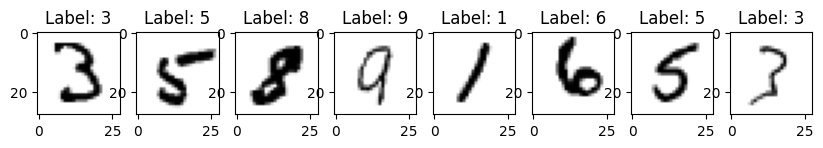

In [ ]:
# Get size of element from train_loader
input_batch = next(iter(train_loader))
print(input_batch[0].size()) # Images
print(input_batch[1].size()) # Labels

# Plot all images in batch horizontally next to each other
fig, ax = plt.subplots(1, batch_size, figsize=(10, 10))
for i in range(batch_size):
    ax[i].imshow(input_batch[0][i].numpy().squeeze(), cmap='gray_r')
    ax[i].set_title("Label: {}".format(input_batch[1][i].numpy()))
plt.show()

### Evaluating model before compression
We measure the model's relevant properties such as number of parameters, model size, and number of FLOPs. 
We also measure the accuracy on the test set before compression. 

Calculating the number of FLOPS is not solely dependent on the model. It depends on the model's input size, which depends on the dataset. 
A model's input size is not always fixed. For example, a linear layer has a fixed input size, but a convolutional layer does not.

In [ ]:
import src.evaluation as evaluation

def get_metrics(model, example_input):
    model_size = evaluation.get_model_size(model)
    print("Model size (MB): {0:.2f}".format(model_size))

    model_parameters = evaluation.get_model_parameters(model)
    print("Model parameters: {0}".format(model_parameters))

    # Input size is necessary for FLOPS calculation, but is dependent on the dataset. 
    model_flops, params = evaluation.get_model_flops(model, example_input.size())
    print("Model FLOPS: {0}".format(model_flops))


input_batch = next(iter(train_loader))
example_input = input_batch[0][0]

get_metrics(model, example_input)

Model size (MB): 1.65
Model parameters: 431080
Model FLOPS: 2.30772M


/home/abel/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Pruning
In this proof of concept we use a simple magnitude pruning technique.

In [ ]:
import torch.nn.utils.prune as prune
# Define the parameters to prune
parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.95,
)

Test again after pruning.

In [ ]:
get_metrics(model, example_input)




# Get size of element from train_loader
input_batch = next(iter(test_loader))
test_batch = next(iter(input_batch))
print(test_batch[0].size()) # Images
print(test_batch[1].size()) # Labels


from src.general import test



test(model, device="cpu", test_loader=next(iter(test_loader)), criterion=torch.nn.CrossEntropyLoss())

# Method that tests the model based on the test

Model size (MB): 3.29
Model parameters: 431080
Model FLOPS: 2.30772M
torch.Size([1000, 1, 28, 28])
torch.Size([1000])
Inputs: 1000
Inputs: 1000
Inputs: 1000
Inputs: 1000
Inputs: 1000
Inputs: 1000
Inputs: 1000
Inputs: 1000
Inputs: 1000
Inputs: 1000


(11.495285153388977, tensor(9.2300))